In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

tf.random.set_seed(42)
np.random.seed(42)

%matplotlib inline

## Download and load the dataset

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)
label_names = ds_info.features["label"].names
print(ds_info)

tfds.core.DatasetInfo(
    name='cifar10',
    version=3.0.2,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    redistribution_info=,
)



## Show examples

horse ship deer 

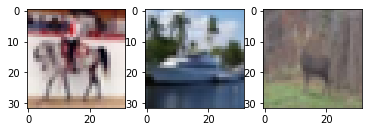

In [3]:
# hand-coded extration
def display_examples(nums=3):
    for i,example in enumerate(ds_train.take(nums)):
        print(label_names[example[-1]], end=' ')
        plt.subplot(100+nums*10+i+1)
        plt.imshow(example[0])
display_examples()

,image,label
0,,4 (deer)
1,,7 (horse)
2,,4 (deer)
3,,6 (frog)

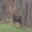
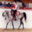
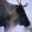
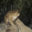

In [4]:
# as pandas dataframe
tfds.as_dataframe(ds_train.take(4), ds_info)

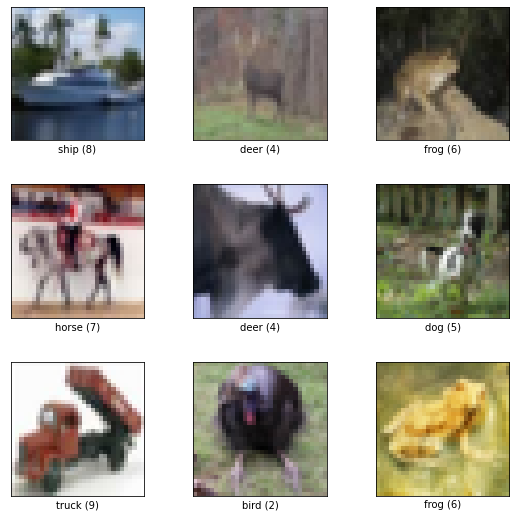

In [5]:
# using show_examples method
fig = tfds.show_examples(ds_train, ds_info)

## DNN Training

In [30]:
(ds_train, ds_valid, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train[:80%]','train[80%:]', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [31]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train[:80%]'].num_examples)
ds_train = ds_train.batch(32)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [32]:
ds_valid = ds_valid.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_valid = ds_valid.batch(128)
ds_valid = ds_valid.cache()
ds_valid = ds_valid.prefetch(tf.data.experimental.AUTOTUNE)

In [33]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [34]:
from tensorflow import keras
from tensorflow.keras.layers import Dense

In [35]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=(32,32,3)))
for _ in range(20):
    model.add(Dense(10, activation='elu', kernel_initializer='he_normal'))
model.add(Dense(10, activation='softmax'))

In [36]:
optimizer = keras.optimizers.Nadam(lr=5e-5)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

### callbacks

In [37]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [39]:
model.fit(ds_train,
          #initial_epoch=0,
          epochs=500,
          validation_data=ds_valid,
          callbacks=callbacks)

Epoch 1/500
1250/1250 [==============================] - 5s 4ms/step - loss: 1.6569 - accuracy: 0.3737 - val_loss: 1.7503 - val_accuracy: 0.3419
Epoch 2/500
1250/1250 [==============================] - 5s 4ms/step - loss: 1.6563 - accuracy: 0.3729 - val_loss: 1.7419 - val_accuracy: 0.3435
Epoch 3/500
1250/1250 [==============================] - 4s 3ms/step - loss: 1.6556 - accuracy: 0.3747 - val_loss: 1.7461 - val_accuracy: 0.3447
Epoch 4/500
1250/1250 [==============================] - 4s 3ms/step - loss: 1.6542 - accuracy: 0.3747 - val_loss: 1.7408 - val_accuracy: 0.3469
Epoch 5/500
1250/1250 [==============================] - 5s 4ms/step - loss: 1.6536 - accuracy: 0.3756 - val_loss: 1.7365 - val_accuracy: 0.3491
Epoch 6/500
1250/1250 [==============================] - 5s 4ms/step - loss: 1.6526 - accuracy: 0.3754 - val_loss: 1.7397 - val_accuracy: 0.3441
Epoch 7/500
1250/1250 [==============================] - 4s 3ms/step - loss: 1.6516 - accuracy: 0.3764 - val_loss: 1.7405 - val_ac

In [41]:
model = keras.models.load_model("my_cifar10_model.h5")
model.evaluate(ds_valid)

79/79 [==============================] - 0s 2ms/step - loss: 1.7296 - accuracy: 0.3532


[1.729606032371521, 0.3531999886035919]

**make a json file to keep record of the accuracy!!**